In [162]:
import pandas as pd
import numpy as np

dataset_path = r"C:\Users\vivia\co-pilot-v1\data\processed_data\parts_data.feather" 
df = pd.read_feather(dataset_path)
# df = pd.read_csv("/Users/skylerwilson/Desktop/PartsMatch/PartsWise/Data/parts_data.csv")
df.head()

,part_number,description,supplier_name,quantity,price,margin,months_no_sale,quantity_ordered_ytd,special_orders_ytd,sales_last_jan,...,one_month_days_supply,annual_turnover,three_month_turnover,one_month_turnover,sales_to_stock_ratio,order_to_sales_ratio,seasonal_component,demand,safety_stock,reorder_point
0,002-10703,exhaust spring 111mm ea,motovan,0,1.99,1.05,15,0,0,20,...,0,0.0,0.0,0,0.0,0.0,0.0,0.000000,0,0
1,004-153,bearing ntn 6203llu/2a 40x17x12,motovan,1,9.99,3.52,13,0,0,0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.000000,0,0
2,004hf113,hi-flo o-filt hon 15412-hm5-a1,thibault canada,1,4.99,1.75,5,0,0,0,...,0,1.0,0.0,0,1.0,0.0,1.0,0.005221,0,0
3,004hf137,hi-flo o-filt suz 16510-37450,thibault canada,0,6.99,2.90,12,0,0,0,...,0,0.0,0.0,0,0.0,0.0,1.0,0.000000,0,0
4,0069922bc,new style universal cruise ctr,thibault canada,1,18.99,9.50,8,0,0,0,...,0,1.0,0.0,0,1.0,0.0,2.0,0.252369,0,0


In [172]:
# all_columns = ['part_number', 'description', 'supplier_name', 'quantity', 'price',
#        'margin', 'months_no_sale', 'quantity_ordered_ytd',
#        'special_orders_ytd', 'sales_last_jan', 'sales_last_feb',
#        'sales_last_mar', 'sales_last_apr', 'sales_last_may', 'sales_last_jun',
#        'sales_last_jul', 'sales_last_aug', 'sales_last_sep', 'sales_last_oct',
#        'sales_last_nov', 'sales_last_dec', 'sales_jan', 'sales_feb',
#        'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 'sales_jul',
#        'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 'sales_dec',
#        'negative_on_hand', 'rolling_12_month_sales', 'rolling_3_month_sales',
#        'cost_per_unit', 'total_cost', 'sales_revenue', 'cogs',
#        'margin_percentage', 'gross_profit', 'roi', 'annual_days_supply',
#        'three_month_days_supply', 'one_month_days_supply', 'annual_turnover',
#        'three_month_turnover', 'one_month_turnover', 'sales_to_stock_ratio',
#        'order_to_sales_ratio', 'seasonal_component', 'demand', 'safety_stock',
#        'reorder_point']

drop_cols = ['part_number', 'description', 'supplier_name',
       'quantity_ordered_ytd',
       'special_orders_ytd', 'sales_last_jan', 'sales_last_feb',
       'sales_last_mar', 'sales_last_apr', 'sales_last_may', 'sales_last_jun',
       'sales_last_jul', 'sales_last_aug', 'sales_last_sep', 'sales_last_oct',
       'sales_last_nov', 'sales_last_dec', 'sales_jan', 'sales_feb',
       'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 'sales_jul',
       'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 'sales_dec',
       'negative_on_hand', 'rolling_12_month_sales', 'rolling_3_month_sales',
       'cogs','roi', 'annual_days_supply',
       'three_month_days_supply', 'one_month_days_supply', 'annual_turnover',
       'three_month_turnover', 'one_month_turnover', 'sales_to_stock_ratio',
       'order_to_sales_ratio', 'seasonal_component', 'safety_stock',
       'reorder_point']

# Variables used: quantity, margin, months no sale, cost per unit, total cost, margin percentage, gross profit, demand
# df = df.loc[df['months_no_sale'] >= 6]
X = df.drop(columns=drop_cols + ['price'])
y = df['price']

In [173]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import RobustScaler, PowerTransformer

In [174]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the model
model = XGBRegressor()

# Define the transformer
transformer = PowerTransformer(method='yeo-johnson')

# Define the scaler
scaler = RobustScaler()

# Create a pipeline for the features
feature_pipeline = Pipeline([
    ('transformer', transformer),
    ('scaler', scaler)
])

# Combine the feature pipeline and the model into a single pipeline
# and apply a power transformation to the target variable
final_pipeline = TransformedTargetRegressor(
    regressor=Pipeline([
        ('feature_pipeline', feature_pipeline),
        ('model', model)
    ]),
    transformer=PowerTransformer(method='yeo-johnson')
)

# Define the parameter grid
param_dist = {
    'regressor__model__n_estimators': [225, 250, 275, 300],
    'regressor__model__learning_rate': [0.01, 0.05, 0.1, 0.25, 0.3],
    'regressor__model__reg_alpha': [0.01, 0.05, 0.1],
    'regressor__model__reg_lambda': [1, 1.25, 1.5],
    'regressor__model__scale_pos_weight': [1, 2, 3],
    'regressor__model__base_score': [0.5],
    'regressor__model__objective': ['reg:squarederror'],
    'regressor__model__booster': ['gbtree', 'gblinear', 'dart'],
    'regressor__model__eval_metric': ['rmse'],
    'regressor__model__random_state': [42],
}


In [175]:

# Set up cross-validation
cv = KFold(n_splits=3, random_state=42, shuffle=True)

# Set up RandomizedSearchCV
search = RandomizedSearchCV(estimator=final_pipeline, param_distributions=param_dist, n_iter=10, cv=cv, random_state=42, n_jobs=-1)

# Fit the model
search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:")
print(search.best_params_)


Best Parameters:
{'regressor__model__scale_pos_weight': 2, 'regressor__model__reg_lambda': 1.25, 'regressor__model__reg_alpha': 0.05, 'regressor__model__random_state': 42, 'regressor__model__objective': 'reg:squarederror', 'regressor__model__n_estimators': 225, 'regressor__model__learning_rate': 0.05, 'regressor__model__eval_metric': 'rmse', 'regressor__model__booster': 'gbtree', 'regressor__model__base_score': 0.5}


In [176]:
# Make predictions on the validation set
predictions = search.predict(X_val)

# Calculate performance metrics
mse = mean_squared_error(y_val, predictions)
r2 = r2_score(y_val, predictions)
mae = mean_absolute_error(y_val, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 248.0872344287839
R^2 Score: 0.9920466829926303
Mean Absolute Error: 1.9107857906487111


In [180]:
additional_info = df.loc[X_val.index, ['part_number', 'description', 'supplier_name', 'quantity',
                                        'months_no_sale', 'special_orders_ytd', 'cost_per_unit', 'sales_revenue', 'gross_profit', 'demand']]
price_diff = np.round(y_val - predictions, 2)
percent_error = np.round(np.abs(y_val - predictions) / y_val * 100, 2)

comparison_df = pd.DataFrame({'Actual Price': y_val, 'Predicted Price': np.round(predictions, 2), 'Price Diff': price_diff, 'Percent Error': percent_error})

# # Merge the dataframes
comparison_df = additional_info.merge(comparison_df, left_index=True, right_index=True)
comparison_df

,part_number,description,supplier_name,quantity,months_no_sale,special_orders_ytd,cost_per_unit,sales_revenue,gross_profit,demand,Actual Price,Predicted Price,Price Diff,Percent Error
9684,76138567486,trousers enduroguard,bmw group canada,0,15,0,650.58,0.00,0.00,0.000000,903.99,905.109985,-1.12,0.12
10223,77252447776,cover panel headlamp machine,bmw group canada,0,7,0,285.11,395.99,110.88,0.906594,395.99,400.350006,-4.36,1.10
8720,7119904533,hex bolt,bmw group canada,9,13,0,2.45,0.00,0.00,0.000000,4.99,4.950000,0.04,0.72
8798,7119906605,o-ring,bmw group canada,15,2,0,2.88,24.95,10.55,0.277316,4.99,4.980000,0.01,0.17
12893,mgvs23808-xxl,ace glove-xxl,triumph motorcycles,0,4,0,77.99,119.99,42.00,0.574744,119.99,120.300003,-0.31,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3528,286289306,mw rd 2 in 1 ls tee l,polaris acceptance,1,14,0,27.20,0.00,0.00,0.000000,67.99,67.309998,0.68,1.00
4503,32728532636,boot,bmw group canada,1,13,0,23.80,0.00,0.00,0.000000,35.99,35.200001,0.79,2.20
2528,2520799,"filter-oil,10 micron,scout",polaris acceptance,12,9,0,9.15,37.98,19.68,0.326243,18.99,19.030001,-0.04,0.21
12831,mgvs2200-001m,triple glv-m,triumph motorcycles,4,16,0,175.48,0.00,0.00,0.000000,269.99,266.859985,3.13,1.16


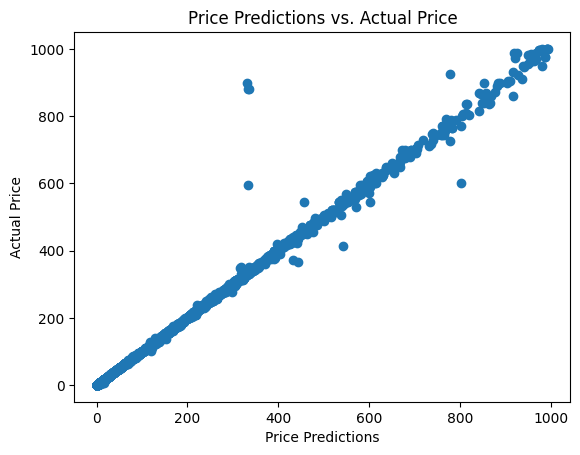

In [181]:
# Plotting predictions vs. actual
import matplotlib.pyplot as plt

plt.plot(predictions, y_val, 'o')
plt.xlabel('Price Predictions')
plt.ylabel("Actual Price")
plt.title("Price Predictions vs. Actual Price")
plt.show()

In [190]:
print("Sum gross profit:", np.sum(comparison_df['gross_profit']))
print("Sum total cost:", np.sum(np.multiply(comparison_df['cost_per_unit'], comparison_df['quantity'])))
print("Sum total possible revenue:", np.sum(np.multiply(comparison_df['Actual Price'], comparison_df['quantity'])))

Sum gross profit: 165426.86
Sum total cost: 450446.56999999995
Sum total possible revenue: 737307.15


In [182]:
outliers_df = comparison_df.loc[comparison_df['Price Diff'] > 50]

outliers_df.loc[outliers_df['months_no_sale'] > 6]

,part_number,description,supplier_name,quantity,months_no_sale,special_orders_ytd,cost_per_unit,sales_revenue,gross_profit,demand,Actual Price,Predicted Price,Price Diff,Percent Error
5921,4377213360,c3 pro matte blk xs,schuberth,0,11,0,424.82,0.00,0.00,0.966738,988.99,924.440002,64.55,6.53
9661,76118568081,tourshell womens,bmw group canada,1,13,0,0.00,0.00,0.00,0.000000,545.99,456.869995,89.12,16.32
15506,t3880072,"charger, batter",triumph,2,15,0,880.68,0.00,0.00,0.000000,880.99,334.500000,546.49,62.03
5623,38540093b,piattaforma inerziale,ducati,1,13,0,777.85,0.00,0.00,0.000000,972.99,920.200012,52.79,5.43
13159,mtpc18407-m-mmp,malvern jacket-m,m & m performance,1,25,0,832.52,0.00,0.00,0.000000,925.99,777.289978,148.70,16.06
15505,t3880071,"charger, batter",triumph,0,8,0,880.68,1761.98,0.62,0.996906,880.99,333.390015,547.60,62.16
4089,2b001199,front brake master,international motorsports,0,14,0,596.75,0.00,0.00,0.000000,596.75,333.750000,263.00,44.07
5910,4371134360,c3 pro white,schuberth,0,12,0,424.82,0.00,0.00,0.000000,988.99,917.549988,71.44,7.22


create the same model as above but only use data that will be available from PartsMatch or something similar:
- Months No Sale --> Time listed on the site
- Quantity --> total quantity matching a particular part number
- Demand --> total sales in a given time period for that part
- Competitive pricing --> Avg or mean price of competitors
- Target --> Price of that part number

Ill have to simplify it for now because I only have dads dealership data but this is similar to what ill build for the ML-algorithmic pricing for PartsMatch

In [ ]:
# cols = ['Sales - Jan', 'Sales - Feb', 'Sales - Mar', 'Sales - Apr',
#        'Sales - May', 'Sales - Jun', 'Sales - Jul', 'Sales - Aug',
#        'Sales - Sep', 'Sales - Oct', 'Sales - Nov', 'Sales - Dec',
#        'Months No Sale', 'Quantity', 'Cost Per Unit', 'Gross Profit',
#        'Margin %']
# PartsMatch = df[cols]

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import RobustScaler, PowerTransformer

# Assuming df is your dataframe and is already loaded
X = PartsMatch.select_dtypes(exclude='object')
y = df['Price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the model
model = XGBRegressor()

# Define the transformer
transformer = PowerTransformer(method='yeo-johnson')

# Define the scaler
scaler = RobustScaler()

# Create a pipeline for the features
feature_pipeline = Pipeline([
    ('transformer', transformer),
    ('scaler', scaler)
])

# Combine the feature pipeline and the model into a single pipeline
# and apply a power transformation to the target variable
final_pipeline = TransformedTargetRegressor(
    regressor=Pipeline([
        ('feature_pipeline', feature_pipeline),
        ('model', model)
    ]),
    transformer=PowerTransformer(method='yeo-johnson')
)

# Define the parameter grid
param_dist = {
    'regressor__model__n_estimators': [250, 275, 300],
    'regressor__model__learning_rate': [0.01, 0.05, 0.1, 0.25],
    'regressor__model__reg_alpha': [0.01, 0.05, 0.1],
    'regressor__model__reg_lambda': [1, 1.25, 1.5],
    'regressor__model__scale_pos_weight': [1, 2, 3],
    'regressor__model__base_score': [0.5],
    'regressor__model__objective': ['reg:squarederror'],
    'regressor__model__booster': ['gbtree', 'gblinear', 'dart'],
    'regressor__model__eval_metric': ['rmse'],
    'regressor__model__random_state': [42],
}

# Set up cross-validation
cv = KFold(n_splits=3, random_state=42, shuffle=True)

# Set up RandomizedSearchCV
search = RandomizedSearchCV(estimator=final_pipeline, param_distributions=param_dist, n_iter=10, cv=cv, random_state=42, n_jobs=-1)

# Fit the model
search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:")
print(search.best_params_)

# Make predictions on the validation set
predictions = search.predict(X_val)

# Calculate performance metrics
mse = mean_squared_error(y_val, predictions)
r2 = r2_score(y_val, predictions)
mae = mean_absolute_error(y_val, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')

Best Parameters:
{'regressor__model__scale_pos_weight': 3, 'regressor__model__reg_lambda': 1, 'regressor__model__reg_alpha': 0.05, 'regressor__model__random_state': 42, 'regressor__model__objective': 'reg:squarederror', 'regressor__model__n_estimators': 275, 'regressor__model__learning_rate': 0.05, 'regressor__model__eval_metric': 'rmse', 'regressor__model__booster': 'dart', 'regressor__model__base_score': 0.5}
Mean Squared Error: 38237.24636799818
R^2 Score: 0.8212963409868623
Mean Absolute Error: 7.13861954144267


In [ ]:
# additional_info_2 = df.loc[X_val.index, ['Part Number', 'Supplier Name', 'Description', 'Quantity', 
#                                        'Cost Per Unit', 'Months No Sale',
#                                        'Understocked', 'Overstocked', 'Essential', 'Non-essential',
#                                        'Nearing Obsolete', 'Obsolete', 'Adjusted Demand']]
        
# # Now 'predictions' contains the prices in the original scale, 
# # and you can compare them directly to 'y_val'
# comparison_df_2 = pd.DataFrame({'Actual Price': y_val, 'Predicted Price': np.round(predictions, 2)})

# # Merge the dataframes
# comparison_df_2 = additional_info.merge(comparison_df_2, left_index=True, right_index=True)

# comparison_df_2['Price Diff'] = np.round(comparison_df_2['Actual Price'] - comparison_df_2['Predicted Price'], 2)

# comparison_df_2['Predicted Price'] = comparison_df_2.apply(
#     lambda row: adjust_price(row['Actual Price'], row['Months No Sale'], row['Cost Per Unit']),
#     axis=1
# )

# comparison_df_2['Predicted Price'] = round(comparison_df_2['Predicted Price'], 2)

# comparison_df_2

,Part Number,Supplier Name,Description,Quantity,Cost Per Unit,Months No Sale,Understocked,Overstocked,Essential,Non-essential,Nearing Obsolete,Obsolete,Adjusted Demand,Actual Price,Predicted Price,Price Diff
18501,981073686,ducati,trousers tour c4 woman xl,1,349.30,7,0,1,0,0,1,0,0.000000,499.99,454.54,6.52
49768,t2046501,triumph,clutch lever,0,2.91,0,0,0,0,1,0,0,0.000000,67.99,67.99,-3.19
16758,40140061a,ducati,speedometer,0,58.04,7,0,0,0,0,1,0,0.000000,116.99,106.35,-0.99
49319,t16-500,moto international,tube,0,8.26,0,0,0,0,1,0,0,0.000000,34.95,34.95,-2.41
5747,t3550380,triumph,"washer, wave",1,3.49,25,0,1,0,0,0,1,0.000000,5.99,3.49,-0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12645,2862797,polaris,icon pin badge,1,10.39,10,0,1,0,0,1,0,0.000000,15.99,10.92,0.04
2780,34317707371,bmw,tandem clamp,0,2.72,1,1,0,1,0,0,0,0.020320,4.49,4.49,-0.01
17295,5h0-83980-09-00,argyll moto internationalrsports,front stop switch,0,25.73,7,0,0,0,0,1,0,0.077364,28.59,25.99,0.78
14856,0340-0813,parts canada/power twins,160/60r15 67h diablo rosso rear,0,256.72,7,0,0,0,0,1,0,0.033954,394.99,359.08,-3.64
